<a href="https://colab.research.google.com/github/protzetter/Kaggle-Experiments/blob/master/TweetswithBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
!pip install bert-for-tf2
!pip install sentencepiece

In [142]:
%tensorflow_version 2.x
 
import tensorflow as tf
import tensorflow_hub as hub
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import numpy as np
from collections import namedtuple
print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)

TensorFlow Version: 2.1.0
Hub version:  0.7.0


In [0]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=False)

In [0]:
MAX_SEQ_LEN=128
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                    name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [0]:
FullTokenizer=bert.bert_tokenization.FullTokenizer

vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()

tokenizer=FullTokenizer(vocab_file,do_lower_case)

In [0]:
import string
import re
import numpy as np
import datetime

In [0]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [0]:
def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [0]:
import pandas as pd
import numpy as np

In [0]:
dataset=pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')
testset=pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv')
submission=pd.read_csv('/content/drive/My Drive/Colab Notebooks/submission.csv')
lengthdata=dataset.shape[0]
yTrain=dataset.target

In [0]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

dataset['text']=dataset['text'].apply(lambda x : remove_URL(x))
testset['text']=testset['text'].apply(lambda x : remove_URL(x))

In [0]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

dataset['text']=dataset['text'].apply(lambda x : remove_html(x))
testset['text']=testset['text'].apply(lambda x : remove_html(x))

In [0]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

dataset['text']=dataset['text'].apply(lambda x: remove_emoji(x))
testset['text']=testset['text'].apply(lambda x: remove_emoji(x))

In [154]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

stopword_set = stopwords.words('english')+['url']
def remove_stopwords(text):
    ret1=re.split("[,_, \<>!\?\.:\n\"=*/]+",text)
    ret2 =" ".join([word for word in ret1 if word not in stopword_set])
    return ret2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [155]:
dataset['text'] = dataset['text'].apply(lambda x: remove_stopwords(x))
testset['text'] = testset['text'].apply(lambda x: remove_stopwords(x))
dataset['text'] = dataset['text'].apply(lambda x: remove_punct(x))
testset['text'] = testset['text'].apply(lambda x: remove_punct(x))
#porter = PorterStemmer()
#dataset['text']= porter.stem(dataset['text'])
dataset.head(10)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds Reason earthquake May ALLAH Forgive us,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked shelter place notified off...,1
3,6,NaN,NaN,people receive wildfires evacuation orders C...,1
4,7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1
5,8,NaN,NaN,RockyFire Update California Hwy closed direct...,1
6,10,NaN,NaN,flood disaster Heavy rain causes flash floodin...,1
7,13,NaN,NaN,Im top hill I see fire woods,1
8,14,NaN,NaN,Theres emergency evacuation happening building...,1
9,15,NaN,NaN,Im afraid tornado coming area,1


In [0]:
def create_single_input(sentence,MAX_LEN):
  
  stokens = tokenizer.tokenize(sentence)
  
  stokens = stokens[:MAX_LEN]
  
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
  ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)

  return ids,masks,segments

In [0]:
def create_input_array(sentences):

  input_ids, input_masks, input_segments = [], [], []

  for sentence in tqdm(sentences,position=0, leave=True):
  
    ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2)

    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)

  return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

In [158]:
train_sentences=dataset["text"].values
inputs=create_input_array(train_sentences)

100%|██████████| 7613/7613 [00:01<00:00, 5336.86it/s]


In [0]:
x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
x = tf.keras.layers.Dropout(0.2)(x)
out = tf.keras.layers.Dense(1, activation="sigmoid", name="dense_output")(x)

model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['MAE'])


In [160]:
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_5 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]          

In [0]:
history=model.fit(inputs,np.array(yTrain),epochs=100,batch_size=32,validation_split=0.2,shuffle=True)

Train on 6090 samples, validate on 1523 samples
Epoch 1/100
6090/6090 [==============================] - 72s 12ms/sample - loss: 0.6815 - MAE: 0.4845 - val_loss: 0.6415 - val_MAE: 0.4650
Epoch 2/100
6090/6090 [==============================] - 66s 11ms/sample - loss: 0.6126 - MAE: 0.4441 - val_loss: 0.5952 - val_MAE: 0.4336
Epoch 3/100
6090/6090 [==============================] - 68s 11ms/sample - loss: 0.5779 - MAE: 0.4181 - val_loss: 0.5604 - val_MAE: 0.4091
Epoch 4/100
6090/6090 [==============================] - 68s 11ms/sample - loss: 0.5521 - MAE: 0.3995 - val_loss: 0.5376 - val_MAE: 0.3895
Epoch 5/100
6090/6090 [==============================] - 69s 11ms/sample - loss: 0.5345 - MAE: 0.3838 - val_loss: 0.5192 - val_MAE: 0.3741
Epoch 6/100
6090/6090 [==============================] - 69s 11ms/sample - loss: 0.5198 - MAE: 0.3709 - val_loss: 0.5067 - val_MAE: 0.3621
Epoch 7/100
6090/6090 [==============================] - 70s 11ms/sample - loss: 0.5087 - MAE: 0.3602 - val_loss: 0.49

In [134]:
test_sentences=testset["text"].values
inputs=create_input_array(test_sentences)

100%|██████████| 3263/3263 [00:00<00:00, 4912.30it/s]


In [135]:

y_pred = model.predict(inputs)

submission['target'] = np.round(y_pred).astype('int')
submission.to_csv('/content/drive/My Drive/Colab Notebooks/model_submission.csv', index=False)
submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.380325
std,3146.427221,0.485541
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


<Figure size 432x288 with 0 Axes>

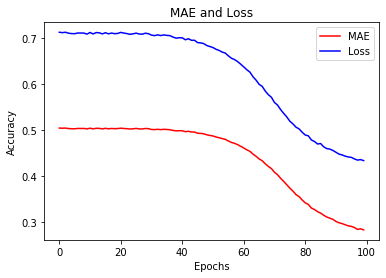

<Figure size 432x288 with 0 Axes>

In [128]:
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['MAE']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()


[1e-08, 0.0001, 0, 1]

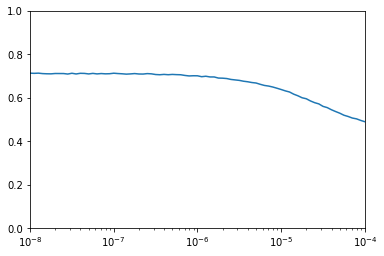

In [137]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 1])